In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit # KFold 대신 TimeSeriesSplit 사용
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from tqdm.auto import tqdm
import warnings
import os
from workalendar.asia import SouthKorea # 공휴일 피처 생성을 위해 추가

In [7]:
building = pd.read_csv('../data/building_info.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [11]:
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])  # 일조와 일사 열 제거

train['is_train'] = 1
test['is_train'] = 0

combined_df = pd.concat([train, test], ignore_index=True)



KeyError: "['일조(hr)', '일사(MJ/m2)'] not found in axis"

In [12]:

# 2. '-' 값을 NaN으로, 그 후 0으로 대체
cols_to_convert = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
for col in cols_to_convert:
    building[col] = pd.to_numeric(building[col].replace('-', np.nan))
    building[col] = building[col].fillna(0)

# 3. 필요한 열만 merge
merged_df = combined_df.merge(
    building[['건물번호'] + cols_to_convert],
    on='건물번호',
    how='left'
)

In [13]:
merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H')


# 2. 시간 기반 파생 피처
merged_df['hour'] = merged_df['일시'].dt.hour                   # 시간대 (0~23)
merged_df['dayofweek'] = merged_df['일시'].dt.dayofweek         # 요일 (월=0 ~ 일=6)
merged_df['month'] = merged_df['일시'].dt.month                 # 월 (1~12)
merged_df['is_weekend'] = (merged_df['dayofweek'] >= 5).astype(int)  # 주말 여부

# 3. 계절 정보
def get_season(month):
    if month in [3, 4, 5]: return 1  # 봄
    elif month in [6, 7, 8]: return 2  # 여름
    elif month in [9, 10, 11]: return 3  # 가을
    else: return 4  # 겨울

merged_df['season'] = merged_df['month'].map(get_season)

# 4. 설비 설치 여부 (0/1)
merged_df['has_solar'] = (merged_df['태양광용량(kW)'] > 0).astype(int)
merged_df['has_ess'] = (merged_df['ESS저장용량(kWh)'] > 0).astype(int)
merged_df['has_pcs'] = (merged_df['PCS용량(kW)'] > 0).astype(int)

# 5. 상호작용 피처 (기온 × 설비)
merged_df['기온x태양광'] = merged_df['기온(°C)'] * merged_df['has_solar']
merged_df['기온xESS'] = merged_df['기온(°C)'] * merged_df['has_ess']

# 6. 체감온도 (Simplified version)
merged_df['체감온도'] = merged_df['기온(°C)'] - ((0.55 - 0.0055 * merged_df['습도(%)']) * (merged_df['기온(°C)'] - 14.5))

# 7. 불쾌지수 (Discomfort Index)
merged_df['불쾌지수'] = 0.81 * merged_df['기온(°C)'] + 0.01 * merged_df['습도(%)'] * (0.99 * merged_df['기온(°C)'] - 14.3) + 46.3

# 8. 전력소비량은 train에만 존재하므로 제외 대상
# 9. 최종적으로 사용하지 않을 열 제거 가능

In [15]:
# 3. 추가 시간 기반 파생 피처
merged_df['year'] = merged_df['일시'].dt.year                    # 연도
merged_df['day'] = merged_df['일시'].dt.day                      # 일 (1~31)
merged_df['quarter'] = merged_df['일시'].dt.quarter                # 분기 (1~4)
merged_df['weekofyear'] = merged_df['일시'].dt.isocalendar().week.astype(int) # 연중 몇 번째 주 (1~53)
merged_df['dayofyear'] = merged_df['일시'].dt.dayofyear              # 연중 몇 번째 날 (1~366)

# 시간대를 나타내는 범주형 피처
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 0  # 오전
    elif 12 <= hour < 18:
        return 1  # 오후
    elif 18 <= hour < 24:
        return 2  # 저녁
    else:
        return 3  # 심야
merged_df['time_of_day'] = merged_df['hour'].apply(get_time_of_day)

# 계절을 나타내는 피처
def get_season(month):
    if 3 <= month <= 5:
        return 0 # 봄
    elif 6 <= month <= 8:
        return 1 # 여름
    elif 9 <= month <= 11:
        return 2 # 가을
    else:
        return 3 # 겨울
merged_df['season'] = merged_df['month'].apply(get_season)

# 월초/월말 여부 (전력 정산일에 따른 패턴이 있을 경우 유용)
merged_df['is_month_start'] = merged_df['일시'].dt.is_month_start.astype(int)
merged_df['is_month_end'] = merged_df['일시'].dt.is_month_end.astype(int)

# 4. 주기성을 나타내는 피처 (Sin/Cos 변환)
# 시간이 순환하는 특징을 모델에 알려줌

# 시간(hour)
merged_df['hour_sin'] = np.sin(2 * np.pi * merged_df['hour'] / 24.0)
merged_df['hour_cos'] = np.cos(2 * np.pi * merged_df['hour'] / 24.0)

# 월(month)
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12.0)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12.0)

# 요일(dayofweek)
merged_df['dayofweek_sin'] = np.sin(2 * np.pi * merged_df['dayofweek'] / 7.0)
merged_df['dayofweek_cos'] = np.cos(2 * np.pi * merged_df['dayofweek'] / 7.0)

In [17]:
# '건물번호'와 '일시'로 정렬이 필수입니다.
merged_df = merged_df.sort_values(by=['건물번호', '일시'])

# --- Lag 피처 (과거 시점의 전력량) ---
# 1일, 2일, 3일, 1주일 전의 동일 시간대 전력량
lags = [24, 48, 72, 168]
for lag in lags:
    merged_df[f'lag_{lag}h'] = merged_df.groupby('건물번호')['전력소비량(kWh)'].transform(
        lambda x: x.shift(lag)
    )

# --- 이동 평균/표준편차 피처 (과거 기간의 트렌드) ---
# 1일(24시간), 1주일(168시간) 동안의 전력량 평균 및 표준편차
rolling_windows = [24, 168]
for window in rolling_windows:
    # shift(1)을 사용하여 현재 시점의 데이터를 포함하지 않도록 함
    merged_df[f'rolling_mean_{window}h'] = merged_df.groupby('건물번호')['전력소비량(kWh)'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    merged_df[f'rolling_std_{window}h'] = merged_df.groupby('건물번호')['전력소비량(kWh)'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )

# Lag/Rolling 피처 생성으로 인한 초기 데이터의 결측치(NaN)를 0으로 채웁니다.
cols_to_fill = [col for col in merged_df.columns if 'lag_' in col or 'rolling_' in col]
merged_df[cols_to_fill] = merged_df[cols_to_fill].fillna(0)

In [18]:
from workalendar.asia import SouthKorea

korean_holidays = SouthKorea()
# 2020년부터 2025년까지의 공휴일 리스트 생성
holidays = []
for year in range(2020, 2026):
    holidays.extend(korean_holidays.holidays(year))

holidays = [holiday[0] for holiday in holidays]

# '일시'의 날짜 부분만 추출하여 공휴일 여부 확인
merged_df['is_holiday'] = merged_df['일시'].dt.date.isin(holidays).astype(int)

In [19]:
merged_df.info()  # 최종 데이터프레임 정보 확인

<class 'pandas.core.frame.DataFrame'>
Index: 220800 entries, 0 to 220799
Data columns (total 47 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   num_date_time      220800 non-null  object        
 1   건물번호               220800 non-null  int64         
 2   일시                 220800 non-null  datetime64[ns]
 3   기온(°C)             220800 non-null  float64       
 4   강수량(mm)            220800 non-null  float64       
 5   풍속(m/s)            220800 non-null  float64       
 6   습도(%)              220800 non-null  float64       
 7   전력소비량(kWh)         204000 non-null  float64       
 8   is_train           220800 non-null  int64         
 9   태양광용량(kW)          220800 non-null  float64       
 10  ESS저장용량(kWh)       220800 non-null  float64       
 11  PCS용량(kW)          220800 non-null  float64       
 12  hour               220800 non-null  int32         
 13  dayofweek          220800 non-null  int32        

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from tqdm.auto import tqdm
import warnings
import os

warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    """SMAPE 계산 함수"""
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    denominator = (np.abs(y_true_exp) + np.abs(y_pred_exp))
    diff = np.where(denominator == 0, 0, np.abs(y_true_exp - y_pred_exp) / denominator)
    return np.mean(diff) * 200

class EnsembleModel:
    def __init__(self, cv_folds=5, random_state=42):
        self.cv_folds = cv_folds
        self.random_state = random_state
        
        self.lgbm_params = {
            'objective': 'regression_l1', 
            'metric': 'mae', 
            'num_leaves': 63,
            'learning_rate': 0.05, 
            'feature_fraction': 0.8, 
            'bagging_fraction': 0.8,
            'n_estimators': 2000, 
            'random_state': random_state, 
            'n_jobs': -1,
            'verbose': -1, 
            'categorical_feature': 'auto'
        }
        
        self.xgb_params = {
            'objective': 'reg:squarederror', 
            'eval_metric': 'mae', 
            'max_depth': 6,
            'learning_rate': 0.05, 
            'subsample': 0.8, 
            'colsample_bytree': 0.8,
            'n_estimators': 2000, 
            'random_state': random_state,
            'tree_method': 'hist', 
            'enable_categorical': True,
            'early_stopping_rounds': 100
        }

    def prepare_data(self, df):
        """데이터 준비: 로그 변환 및 분리"""
        df_processed = df.copy()
        train_mask = df_processed['is_train'] == 1
        
        # 훈련 데이터의 타겟만 로그 변환
        df_processed.loc[train_mask, '전력소비량(kWh)'] = np.log1p(df_processed.loc[train_mask, '전력소비량(kWh)'])
        
        # 제거할 컬럼 (메타데이터)
        drop_cols = ['num_date_time', '일시', 'is_train']
        target_col = '전력소비량(kWh)'
        
        # 범주형 피처 처리
        categorical_cols = ['건물번호', 'hour', 'dayofweek', 'month', 'season', 'time_of_day',
                           'is_weekend', 'is_holiday']
        
        for col in categorical_cols:
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].astype('category')
        
        # 건물 설비 관련 피처 생성 (태양광, ESS, PCS 용량 기반)
        if '태양광용량(kW)' in df_processed.columns:
            df_processed['has_solar'] = (df_processed['태양광용량(kW)'] > 0).astype('category')
        if 'ESS저장용량(kWh)' in df_processed.columns:
            df_processed['has_ess'] = (df_processed['ESS저장용량(kWh)'] > 0).astype('category')
        if 'PCS용량(kW)' in df_processed.columns:
            df_processed['has_pcs'] = (df_processed['PCS용량(kW)'] > 0).astype('category')
        
        # 훈련/테스트 분리
        train_df = df_processed[train_mask]
        test_df = df_processed[~train_mask]
        
        X_train = train_df.drop(columns=drop_cols + [target_col])
        y_train_log = train_df[target_col]
        X_test = test_df.drop(columns=drop_cols + [target_col])
        
        print(f"훈련 데이터: {X_train.shape}, 테스트 데이터: {X_test.shape}")
        print(f"피처 목록: {list(X_train.columns)}")
        
        return X_train, y_train_log, X_test

    def cross_validate_model(self, model_name, X_train, y_train_log, X_test, params):
        """단일 모델 교차 검증"""
        tscv = TimeSeriesSplit(n_splits=self.cv_folds)
        oof_preds = np.zeros(len(X_train))
        test_preds = np.zeros(len(X_test))
        scores = []
        
        print(f"\n=== {model_name.upper()} 교차 검증 (TimeSeriesSplit) ===")
        
        fold_test_preds = []
        
        for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train), desc=f"{model_name} CV", total=self.cv_folds)):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
            
            if model_name == 'lgbm':
                model = LGBMRegressor(**params)
                model.fit(X_tr, y_tr, 
                         eval_set=[(X_val, y_val)], 
                         callbacks=[lgbm.early_stopping(100, verbose=False)])
            elif model_name == 'xgb':
                model = XGBRegressor(**params)
                model.fit(X_tr, y_tr, 
                         eval_set=[(X_val, y_val)],
                         verbose=False)
            
            # 검증 세트 예측
            val_pred = model.predict(X_val)
            oof_preds[val_idx] = val_pred
            
            # 테스트 세트 예측
            test_pred = model.predict(X_test)
            fold_test_preds.append(test_pred)
            
            # 점수 계산
            fold_score = smape(y_val, val_pred)
            scores.append(fold_score)
            print(f"Fold {fold+1} SMAPE: {fold_score:.4f}")
        
        # 테스트 예측값은 모든 fold의 평균
        test_preds = np.mean(fold_test_preds, axis=0)
        
        avg_score = np.mean(scores)
        print(f"평균 SMAPE: {avg_score:.4f} (±{np.std(scores):.4f})")
        
        return oof_preds, test_preds, avg_score

    def fit_predict(self, df):
        """전체 파이프라인 실행"""
        X_train, y_train_log, X_test = self.prepare_data(df)
        
        # 개별 모델 훈련
        lgbm_oof, lgbm_pred, lgbm_score = self.cross_validate_model('lgbm', X_train, y_train_log, X_test, self.lgbm_params)
        xgb_oof, xgb_pred, xgb_score = self.cross_validate_model('xgb', X_train, y_train_log, X_test, self.xgb_params)
        
        # 가중 앙상블 (성능 역수로 가중치 계산)
        scores = np.array([lgbm_score, xgb_score])
        weights = 1 / scores
        weights /= weights.sum()
        
        print(f"\n앙상블 가중치: LGBM={weights[0]:.3f}, XGB={weights[1]:.3f}")
        
        ensemble_pred_log = weights[0] * lgbm_pred + weights[1] * xgb_pred
        ensemble_oof_log = weights[0] * lgbm_oof + weights[1] * xgb_oof
        
        # 스태킹 앙상블
        meta_features_train = np.column_stack([lgbm_oof, xgb_oof])
        meta_features_test = np.column_stack([lgbm_pred, xgb_pred])
        meta_model = Ridge(alpha=0.1)
        meta_model.fit(meta_features_train, y_train_log)
        stacked_pred_log = meta_model.predict(meta_features_test)
        stacked_oof_log = meta_model.predict(meta_features_train)
        
        # 최종 예측값 (로그 역변환 및 음수 방지)
        final_predictions = {
            'lgbm': np.maximum(np.expm1(lgbm_pred), 0),
            'xgb': np.maximum(np.expm1(xgb_pred), 0),
            'weighted': np.maximum(np.expm1(ensemble_pred_log), 0),
            'stacked': np.maximum(np.expm1(stacked_pred_log), 0)
        }
        
        # OOF 점수 계산
        scores_dict = {
            'lgbm': lgbm_score, 
            'xgb': xgb_score,
            'weighted': smape(y_train_log, ensemble_oof_log),
            'stacked': smape(y_train_log, stacked_oof_log)
        }
        
        print(f"\n=== 최종 OOF 점수 ===")
        for name, score in scores_dict.items():
            print(f"{name.capitalize()}: {score:.4f}")
            
        return final_predictions, scores_dict

    def save_submissions(self, df, predictions, scores):
        """제출 파일 저장"""
        os.makedirs('../submissions', exist_ok=True)
        test_ids = df[df['is_train'] == 0]['num_date_time'].values
        
        for method, pred in predictions.items():
            score = scores.get(method, 0)
            filename = f"../submissions/submission_{method}_SMAPE_{score:.4f}.csv"
            submission = pd.DataFrame({'num_date_time': test_ids, 'answer': pred})
            submission.to_csv(filename, index=False)
            print(f"저장: {filename}")

# 모델 학습 및 예측 실행
print("모델 훈련 및 예측 시작...")
model = EnsembleModel(cv_folds=5, random_state=42)
predictions, scores = model.fit_predict(merged_df)

print("\n제출 파일 저장 시작...")
model.save_submissions(merged_df, predictions, scores)
print("모든 과정 완료!")

# 결과 확인
print("\n=== 최종 결과 요약 ===")
best_method = min(scores.items(), key=lambda x: x[1])
print(f"최고 성능 모델: {best_method[0]} (SMAPE: {best_method[1]:.4f})")

# 예측값 분포 확인
for method, pred in predictions.items():
    print(f"{method}: 평균={pred.mean():.2f}, 최소={pred.min():.2f}, 최대={pred.max():.2f}")

# 건물 설비 정보 요약
if '태양광용량(kW)' in merged_df.columns:
    solar_buildings = (merged_df['태양광용량(kW)'] > 0).sum()
    print(f"\n태양광 설비 건물 수: {solar_buildings}")
if 'ESS저장용량(kWh)' in merged_df.columns:
    ess_buildings = (merged_df['ESS저장용량(kWh)'] > 0).sum()
    print(f"ESS 설비 건물 수: {ess_buildings}")
if 'PCS용량(kW)' in merged_df.columns:
    pcs_buildings = (merged_df['PCS용량(kW)'] > 0).sum()
    print(f"PCS 설비 건물 수: {pcs_buildings}")

모델 훈련 및 예측 시작...
훈련 데이터: (204000, 43), 테스트 데이터: (16800, 43)
피처 목록: ['건물번호', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'hour', 'dayofweek', 'month', 'is_weekend', 'season', 'has_solar', 'has_ess', 'has_pcs', '기온x태양광', '기온xESS', '체감온도', '불쾌지수', 'year', 'day', 'quarter', 'weekofyear', 'dayofyear', 'time_of_day', 'is_month_start', 'is_month_end', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'lag_24h', 'lag_48h', 'lag_72h', 'lag_168h', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_std_168h', 'is_holiday']

=== LGBM 교차 검증 (TimeSeriesSplit) ===


lgbm CV:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 SMAPE: 23.6857
Fold 2 SMAPE: 12.7938
Fold 3 SMAPE: 20.0387
Fold 4 SMAPE: 10.9117
Fold 5 SMAPE: 21.7840
평균 SMAPE: 17.8428 (±5.0602)

=== XGB 교차 검증 (TimeSeriesSplit) ===


xgb CV:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 SMAPE: 50.4336
Fold 2 SMAPE: 28.8460
Fold 3 SMAPE: 39.9666
Fold 4 SMAPE: 33.7804
Fold 5 SMAPE: 71.9471
평균 SMAPE: 44.9947 (±15.2829)

앙상블 가중치: LGBM=0.716, XGB=0.284

=== 최종 OOF 점수 ===
Lgbm: 17.8428
Xgb: 44.9947
Weighted: 54.4001
Stacked: 55.3632

제출 파일 저장 시작...
저장: ../submissions/submission_lgbm_SMAPE_17.8428.csv
저장: ../submissions/submission_xgb_SMAPE_44.9947.csv
저장: ../submissions/submission_weighted_SMAPE_54.4001.csv
저장: ../submissions/submission_stacked_SMAPE_55.3632.csv
모든 과정 완료!

=== 최종 결과 요약 ===
최고 성능 모델: lgbm (SMAPE: 17.8428)
lgbm: 평균=1847.86, 최소=203.30, 최대=18792.10
xgb: 평균=2192.87, 최소=342.84, 최대=18272.93
weighted: 평균=1916.79, 최소=261.09, 최대=18626.06
stacked: 평균=3038.36, 최소=263.24, 최대=12349.82

태양광 설비 건물 수: 117024
ESS 설비 건물 수: 26496
PCS 설비 건물 수: 26496


In [45]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

피처 상관관계 분석을 시작합니다...
종합적인 피처 상관관계 분석 시작

1. 전체 피처 상관관계 히트맵 생성...
상관관계 분석을 위한 데이터 준비 중...
분석 대상 피처 수: 44
분석 데이터 크기: (204000, 44)
상관관계 행렬 계산 중...


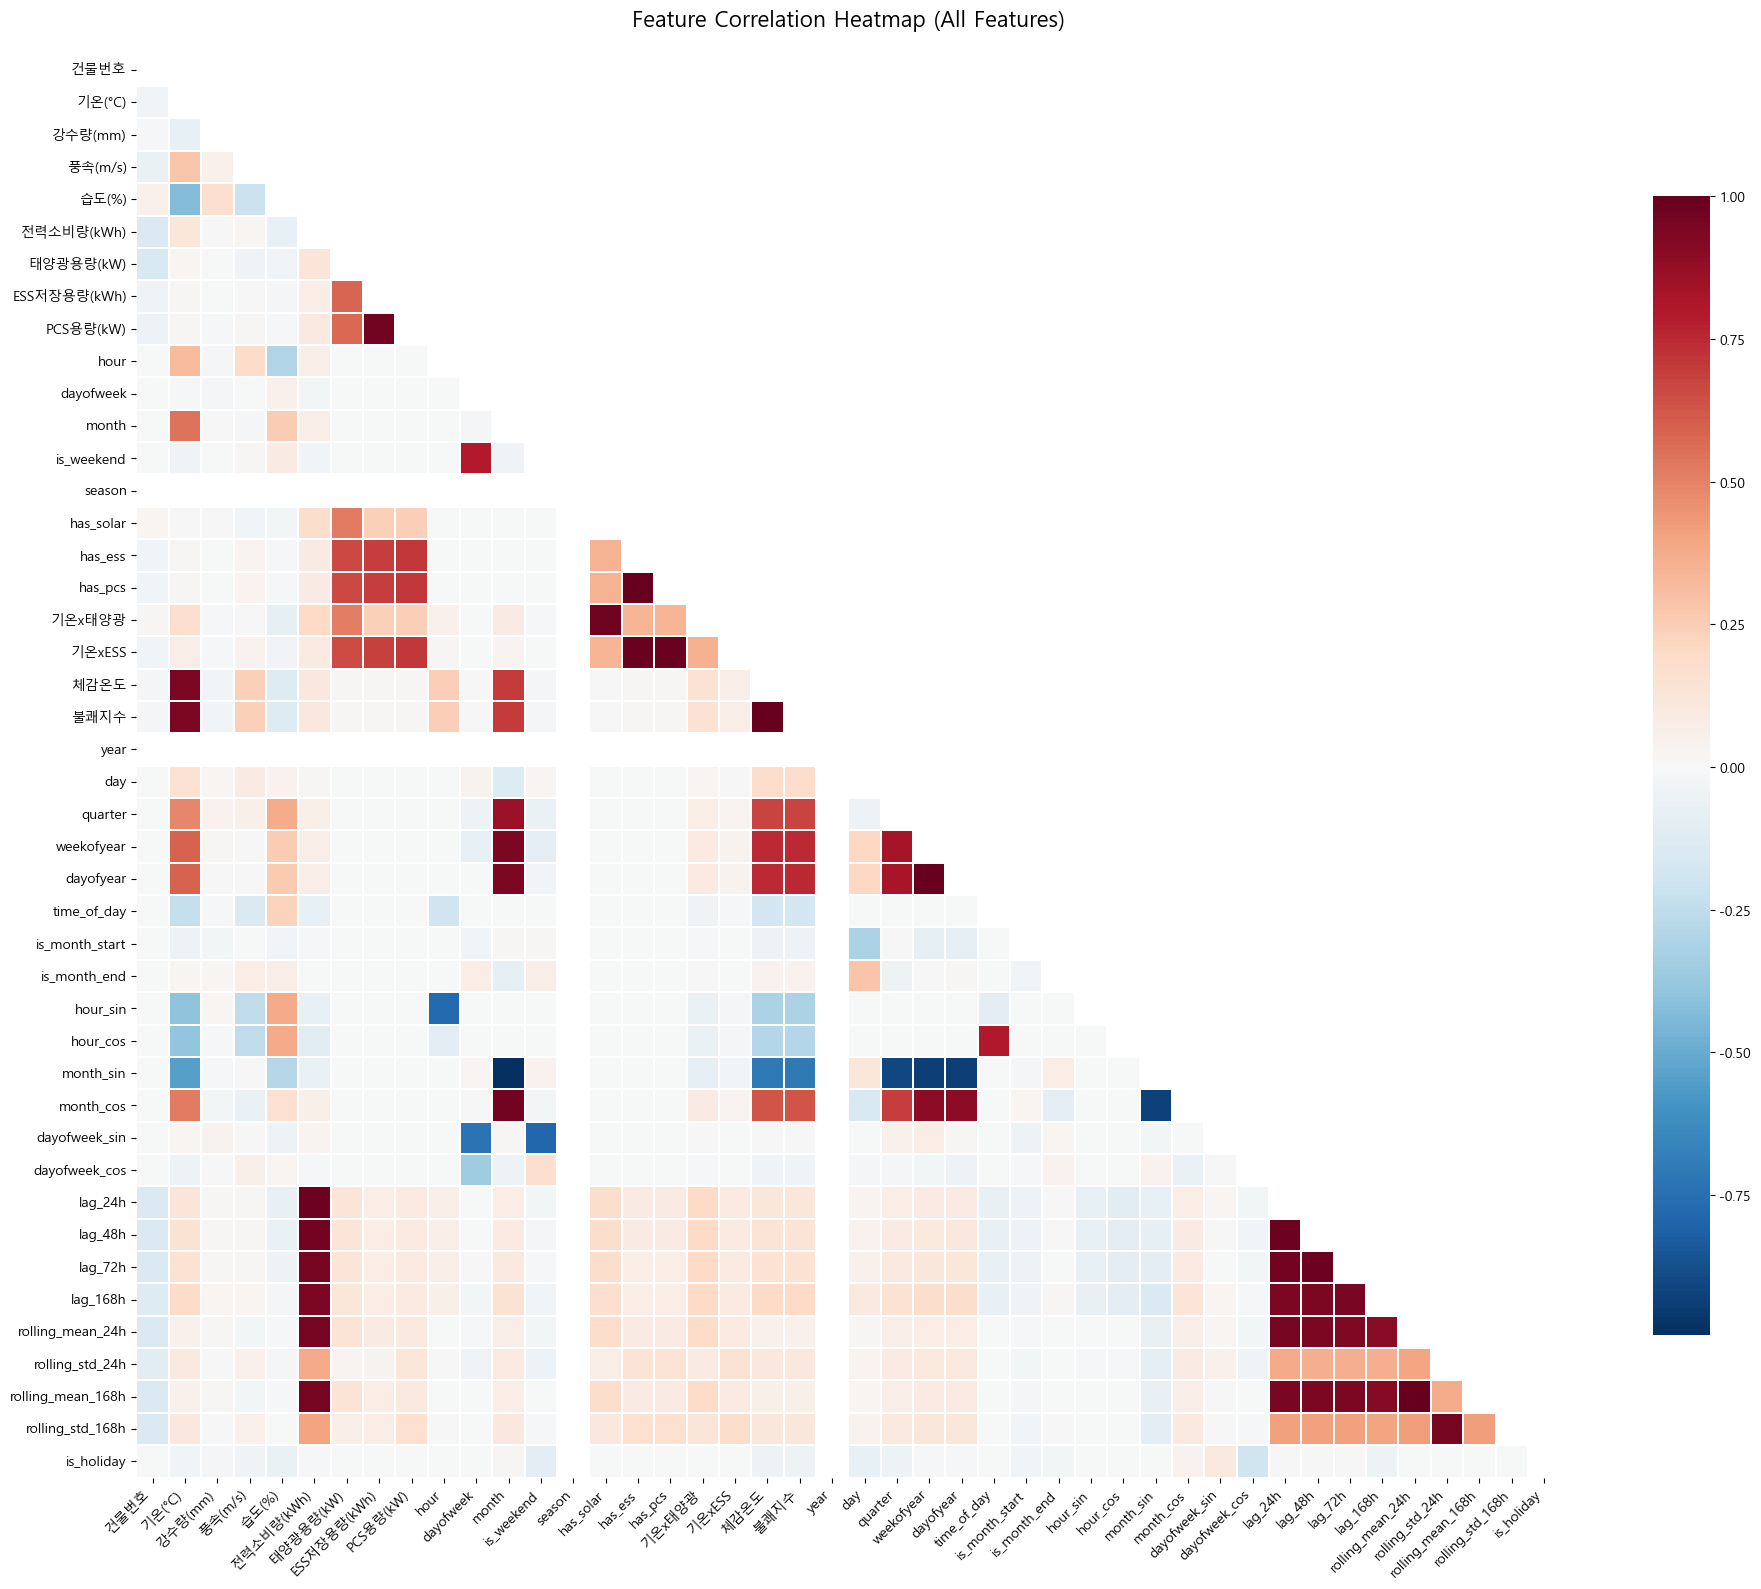


2. 높은 상관관계 피처 쌍 분석...

=== 높은 상관관계 피처 분석 (임계값: 0.8) ===
발견된 높은 상관관계 쌍 수: 45

상위 10개 높은 상관관계:
        feature1          feature2  correlation
         has_ess           has_pcs     1.000000
            체감온도              불쾌지수     0.999999
      weekofyear         dayofyear     0.996695
           month         month_sin    -0.995704
rolling_mean_24h rolling_mean_168h     0.995469
         has_ess            기온xESS     0.987018
         has_pcs            기온xESS     0.987018
         lag_48h           lag_72h     0.981317
         lag_24h           lag_48h     0.981308
      전력소비량(kWh)           lag_24h     0.981142

저장: ../submissions/high_correlation_pairs.csv

3. 타겟 변수와의 상관관계 분석...

=== 전력소비량(kWh)과의 상관관계 분석 ===


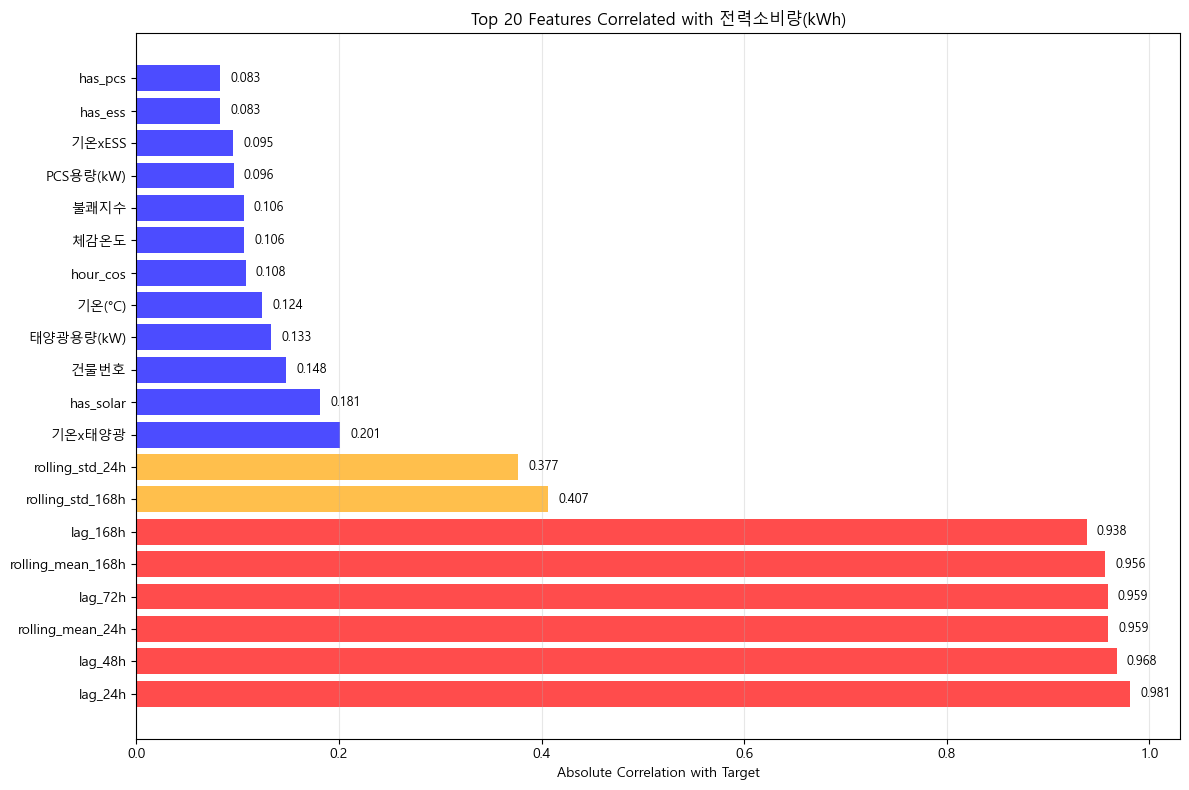


Top 20 타겟 상관관계:
lag_24h              0.981142
lag_48h              0.967873
rolling_mean_24h     0.959190
lag_72h              0.958680
rolling_mean_168h    0.956391
lag_168h             0.937957
rolling_std_168h     0.406692
rolling_std_24h      0.376943
기온x태양광               0.200967
has_solar            0.181193
건물번호                 0.147515
태양광용량(kW)            0.133138
기온(°C)               0.124400
hour_cos             0.107902
체감온도                 0.106119
불쾌지수                 0.106010
PCS용량(kW)            0.095957
기온xESS               0.095422
has_ess              0.082675
has_pcs              0.082675

저장: ../submissions/target_correlation.csv

4. Lag/Rolling 피처 상관관계 분석...

=== Lag 및 Rolling 피처 상관관계 분석 ===


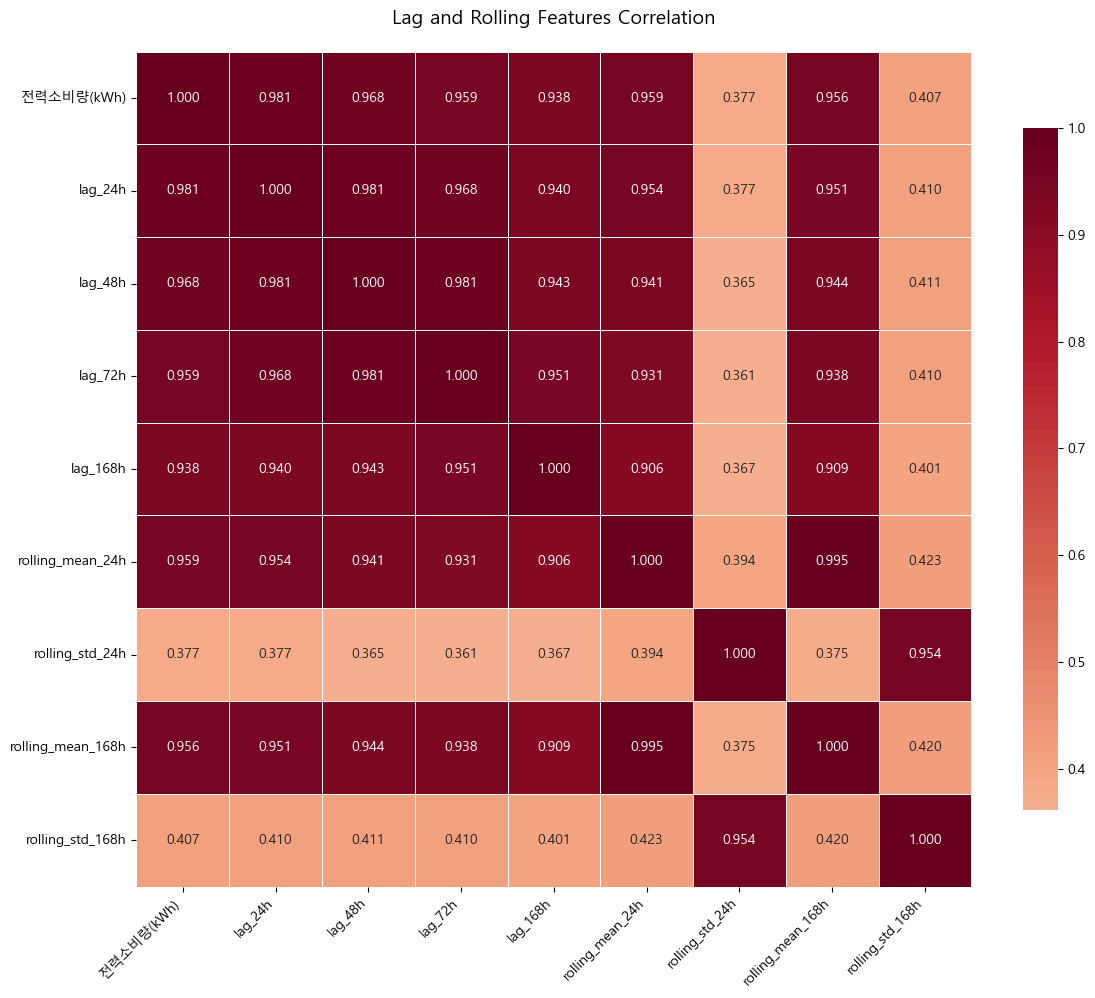

Lag/Rolling 피처 수: 9
분석된 피처들: ['전력소비량(kWh)', 'lag_24h', 'lag_48h', 'lag_72h', 'lag_168h', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_std_168h']

상관관계 분석 완료!
생성된 파일들:
- ../submissions/correlation_heatmap_all.png
- ../submissions/target_correlation.png
- ../submissions/lag_rolling_correlation.png
- ../submissions/high_correlation_pairs.csv
- ../submissions/target_correlation.csv


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import font_manager
import warnings

warnings.filterwarnings('ignore')


def create_correlation_heatmap(df, figsize=(20, 16), save_path='../submissions/'):
    """
    피처들 간의 상관관계 히트맵 생성
    """
    
    print("상관관계 분석을 위한 데이터 준비 중...")
    
    # 훈련 데이터만 사용 (타겟이 있는 데이터)
    train_data = df[df['is_train'] == 1].copy()
    
    # 제거할 컬럼들 (상관관계 분석에 불필요)
    cols_to_drop = ['num_date_time', '일시', 'is_train']
    analysis_df = train_data.drop(columns=[col for col in cols_to_drop if col in train_data.columns])
    
    # 범주형 변수들을 숫자로 변환
    categorical_cols = analysis_df.select_dtypes(include=['category']).columns
    for col in categorical_cols:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].cat.codes
    
    print(f"분석 대상 피처 수: {len(analysis_df.columns)}")
    print(f"분석 데이터 크기: {analysis_df.shape}")
    
    # 상관관계 계산
    print("상관관계 행렬 계산 중...")
    correlation_matrix = analysis_df.corr()
    
    # 1. 전체 상관관계 히트맵
    plt.figure(figsize=figsize)
    
    # 마스크 생성 (상삼각형 제거)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=False,  # 전체는 숫자 표시 안함
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.1,
                cbar_kws={"shrink": .8})
    
    plt.title('Feature Correlation Heatmap (All Features)', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{save_path}correlation_heatmap_all.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix

def analyze_high_correlations(correlation_matrix, threshold=0.8):
    """
    높은 상관관계를 가진 피처 쌍 분석
    """
    print(f"\n=== 높은 상관관계 피처 분석 (임계값: {threshold}) ===")
    
    # 상관관계 행렬의 상삼각형만 고려 (중복 제거)
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # 높은 상관관계 찾기
    high_corr_pairs = []
    for col in upper_triangle.columns:
        for idx in upper_triangle.index:
            corr_value = upper_triangle.loc[idx, col]
            if pd.notna(corr_value) and abs(corr_value) >= threshold:
                high_corr_pairs.append({
                    'feature1': idx,
                    'feature2': col, 
                    'correlation': corr_value
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        high_corr_df = high_corr_df.sort_values('correlation', key=abs, ascending=False)
        
        print(f"발견된 높은 상관관계 쌍 수: {len(high_corr_df)}")
        print("\n상위 10개 높은 상관관계:")
        print(high_corr_df.head(10).to_string(index=False))
        
        # CSV로 저장
        high_corr_df.to_csv('../submissions/high_correlation_pairs.csv', index=False)
        print(f"\n저장: ../submissions/high_correlation_pairs.csv")
        
        return high_corr_df
    else:
        print("높은 상관관계를 가진 피처 쌍이 없습니다.")
        return pd.DataFrame()

def plot_target_correlation(df, target_col='전력소비량(kWh)', top_n=20):
    """
    타겟 변수와의 상관관계 분석
    """
    print(f"\n=== {target_col}과의 상관관계 분석 ===")
    
    # 훈련 데이터만 사용
    train_data = df[df['is_train'] == 1].copy()
    
    # 제거할 컬럼들
    cols_to_drop = ['num_date_time', '일시', 'is_train']
    analysis_df = train_data.drop(columns=[col for col in cols_to_drop if col in train_data.columns])
    
    # 범주형 변수들을 숫자로 변환
    categorical_cols = analysis_df.select_dtypes(include=['category']).columns
    for col in categorical_cols:
        if col in analysis_df.columns:
            analysis_df[col] = analysis_df[col].cat.codes
    
    # 타겟과의 상관관계 계산
    target_corr = analysis_df.corr()[target_col].abs().sort_values(ascending=False)
    target_corr = target_corr.drop(target_col)  # 자기 자신 제외
    
    # 상위 N개 피처 시각화
    plt.figure(figsize=(12, 8))
    top_features = target_corr.head(top_n)
    
    colors = ['red' if x > 0.5 else 'orange' if x > 0.3 else 'blue' for x in top_features.values]
    
    bars = plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Absolute Correlation with Target')
    plt.title(f'Top {top_n} Features Correlated with {target_col}')
    plt.grid(axis='x', alpha=0.3)
    
    # 값 표시
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../submissions/target_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTop {top_n} 타겟 상관관계:")
    print(target_corr.head(top_n).to_string())
    
    # CSV로 저장
    target_corr.to_csv('../submissions/target_correlation.csv')
    print(f"\n저장: ../submissions/target_correlation.csv")
    
    return target_corr

def plot_lag_features_heatmap(df):
    """
    Lag 피처들과 rolling 피처들 간의 상관관계 분석
    """
    print("\n=== Lag 및 Rolling 피처 상관관계 분석 ===")
    
    # 훈련 데이터만 사용
    train_data = df[df['is_train'] == 1].copy()
    
    # lag와 rolling 피처들만 선택
    lag_rolling_cols = [col for col in train_data.columns 
                       if 'lag_' in col or 'rolling_' in col or col == '전력소비량(kWh)']
    
    if len(lag_rolling_cols) > 1:
        lag_data = train_data[lag_rolling_cols]
        
        # 상관관계 계산
        lag_corr = lag_data.corr()
        
        # 히트맵 생성
        plt.figure(figsize=(12, 10))
        sns.heatmap(lag_corr, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": .8},
                    fmt='.3f')
        
        plt.title('Lag and Rolling Features Correlation', fontsize=14, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('../submissions/lag_rolling_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Lag/Rolling 피처 수: {len(lag_rolling_cols)}")
        print(f"분석된 피처들: {lag_rolling_cols}")
        
        return lag_corr
    else:
        print("Lag/Rolling 피처가 충분하지 않습니다.")
        return None

def comprehensive_correlation_analysis(df):
    """
    종합적인 상관관계 분석
    """
    print("="*60)
    print("종합적인 피처 상관관계 분석 시작")
    print("="*60)
    
    # 1. 전체 상관관계 히트맵
    print("\n1. 전체 피처 상관관계 히트맵 생성...")
    correlation_matrix = create_correlation_heatmap(df)
    
    # 2. 높은 상관관계 분석
    print("\n2. 높은 상관관계 피처 쌍 분석...")
    high_corr_pairs = analyze_high_correlations(correlation_matrix, threshold=0.8)
    
    # 3. 타겟과의 상관관계
    print("\n3. 타겟 변수와의 상관관계 분석...")
    target_corr = plot_target_correlation(df)
    
    # 4. Lag/Rolling 피처 분석
    print("\n4. Lag/Rolling 피처 상관관계 분석...")
    lag_corr = plot_lag_features_heatmap(df)
    
    print("\n" + "="*60)
    print("상관관계 분석 완료!")
    print("="*60)
    print("생성된 파일들:")
    print("- ../submissions/correlation_heatmap_all.png")
    print("- ../submissions/target_correlation.png") 
    print("- ../submissions/lag_rolling_correlation.png")
    print("- ../submissions/high_correlation_pairs.csv")
    print("- ../submissions/target_correlation.csv")
    
    return {
        'correlation_matrix': correlation_matrix,
        'high_corr_pairs': high_corr_pairs,
        'target_correlation': target_corr,
        'lag_correlation': lag_corr
    }

# 실행
print("피처 상관관계 분석을 시작합니다...")
results = comprehensive_correlation_analysis(merged_df)